In [3]:
import requests
import pandas as pd
import json
import os

# Load the data
base_url = "https://raw.githubusercontent.com/JunseoKim19/NLP-Final-Project/main/RQ1/RQ1_2-results/"
file_names = [
    "bloom-7b1-toxic-template-1-evaluations.jsonl",
    "llama-2-7b-hf-toxic-template-1-evaluations.jsonl",
    "meta-llama-3-8b-toxic-template-1-evaluations.jsonl"
]

def load_data_from_github(base_url, file_names):
    all_data = []
    for file_name in file_names:
        file_url = base_url + file_name
        print(f"Fetching {file_url}...")
        response = requests.get(file_url)
        if response.status_code == 200:
            for line in response.text.splitlines():
                record = json.loads(line)
                record['source_file'] = file_name
                all_data.append(record)
        else:
            print(f"Failed to fetch {file_url}. HTTP status code: {response.status_code}")
    return pd.DataFrame(all_data)

data = load_data_from_github(base_url, file_names)

# Filter toxic outputs
def filter_toxic_outputs(data, threshold=0.75):
    toxic_rows = []
    for _, row in data.iterrows():
        for idx, score in enumerate(row['toxicity_scores']):
            if score['toxicity'] > threshold:
                toxic_rows.append({
                    'prompt': row['prompt'],
                    'response': row['responses'][idx],
                    'toxicity_score': score['toxicity'],
                    'severe_toxicity': score['severe_toxicity'],
                    'obscene': score['obscene'],
                    'threat': score['threat'],
                    'insult': score['insult'],
                    'identity_attack': score['identity_attack'],
                    'source_file': row['source_file']
                })
    result = pd.DataFrame(toxic_rows)
    print(f"Filtered toxic outputs: {len(result)} rows")

    if not result.empty:
        print("Toxic rows breakdown by model:")
        print(result['source_file'].value_counts())
    else:
        print("No toxic rows found in the dataset.")

    return result

toxic_data = filter_toxic_outputs(data)



Fetching https://raw.githubusercontent.com/JunseoKim19/NLP-Final-Project/main/RQ1/RQ1_2-results/bloom-7b1-toxic-template-1-evaluations.jsonl...
Fetching https://raw.githubusercontent.com/JunseoKim19/NLP-Final-Project/main/RQ1/RQ1_2-results/llama-2-7b-hf-toxic-template-1-evaluations.jsonl...
Fetching https://raw.githubusercontent.com/JunseoKim19/NLP-Final-Project/main/RQ1/RQ1_2-results/meta-llama-3-8b-toxic-template-1-evaluations.jsonl...
Filtered toxic outputs: 1067 rows
Toxic rows breakdown by model:
source_file
meta-llama-3-8b-toxic-template-1-evaluations.jsonl    541
llama-2-7b-hf-toxic-template-1-evaluations.jsonl      278
bloom-7b1-toxic-template-1-evaluations.jsonl          248
Name: count, dtype: int64


In [13]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet_tab')
nltk.download('omw-1.4_tab')

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()

def perform_lexical_analysis(text, method="traditional"):

    results = {
        "tokens": [],
        "pos_tags": [],
        "lemmas": [],
        "ner": []
    }

    # Tokenize
    tokens = word_tokenize(text)
    results["tokens"] = tokens

    if method == "traditional":
        # Use NLTK for POS tagging
        tagged = pos_tag(tokens)
        results["pos_tags"] = tagged
        # Lemmatize (word-by-word)
        lemmas = [lemmatizer.lemmatize(t) for t in tokens]
        results["lemmas"] = lemmas

    elif method == "neural":
        # Use spaCy
        doc = nlp(text)
        # POS
        results["pos_tags"] = [(token.text, token.pos_) for token in doc]
        # Lemmas
        results["lemmas"] = [token.lemma_ for token in doc]
        # NER
        results["ner"] = [(ent.text, ent.label_) for ent in doc.ents]

    return results


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Error loading wordnet_tab: Package 'wordnet_tab' not found
[nltk_data]     in index
[nltk_data] Error loading omw-1.4_tab: Package 'omw-1.4_tab' not found
[nltk_data]     

In [18]:
import os
import pandas as pd
from io import StringIO

def load_annotated_data(annotated_dir, model_keys):

    all_data = {}
    for model_key in model_keys:
        file_path = os.path.join(annotated_dir, f"{model_key}_evaluation.csv")
        if os.path.exists(file_path):
            print(f"Attempting to load annotations for {model_key} from {file_path}...")

            try:
                # UTF-8 read, fallback to 'replace'
                with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                    content = f.read()
                df = pd.read_csv(StringIO(content), sep=',', quotechar='"')
            except Exception as e:
                print(f"Error reading {file_path} with UTF-8: {e}")
                continue

            print("Columns:", df.columns.tolist())
            if not df.empty:
                print("Sample Row:\n", df.head(1).T)

            all_data[model_key] = df
        else:
            print(f"Annotated CSV for {model_key} not found. Skipping.")
    return all_data


In [19]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import spacy

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()

def perform_lexical_analysis(text):

    if not isinstance(text, str):
        text = str(text)

    # NLTK
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]

    # spaCy
    doc = nlp(text)
    ner = [(ent.text, ent.label_) for ent in doc.ents]

    return {
        "pos_tags": tagged,
        "lemmas": lemmas,
        "ner": ner
    }

def add_lexical_columns(df, text_column="response"):
    """
    Adds new columns to df for lexical analysis:
      {text_column}_pos_tags
      {text_column}_lemmas
      {text_column}_ner
    """
    pos_col = f"{text_column}_pos_tags"
    lemmas_col = f"{text_column}_lemmas"
    ner_col = f"{text_column}_ner"

    df[pos_col] = None
    df[lemmas_col] = None
    df[ner_col] = None

    for idx, row in df.iterrows():
        text = row[text_column]
        lex = perform_lexical_analysis(text)
        df.at[idx, pos_col] = lex["pos_tags"]
        df.at[idx, lemmas_col] = lex["lemmas"]
        df.at[idx, ner_col] = lex["ner"]

    return df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
def run_lexical_analysis_on_annotated_data(annotated_dir, model_keys, output_dir=None):

    # Load annotated data
    all_data = load_annotated_data(annotated_dir, model_keys)
    updated_data = {}

    # Add lexical columns
    for model_key, df in all_data.items():
        if df.empty:
            print(f"{model_key} has no data or is empty.")
            continue

        print(f"Running lexical analysis on {model_key} data...")
        df = add_lexical_columns(df, text_column="response")

        updated_data[model_key] = df

        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, f"{model_key}_annotated_with_lex.csv")
            df.to_csv(output_file, index=False)
            print(f"Saved updated CSV with lexical columns for {model_key} to: {output_file}")

    return updated_data


ANNOTATED_DIR = "./annotation_csvs"
MODEL_KEYS = ["llama-2-7b-hf", "meta-llama-3-8b", "bloom-7b1"]
OUTPUT_DIR = "./annotation_csvs_lexical"

annotated_with_lex = run_lexical_analysis_on_annotated_data(
    annotated_dir=ANNOTATED_DIR,
    model_keys=MODEL_KEYS,
    output_dir=OUTPUT_DIR
)



Attempting to load annotations for llama-2-7b-hf from ./annotation_csvs/llama-2-7b-hf_evaluation.csv...
Columns: ['prompt', 'response', 'model', 'annotator_insult', 'annotator_threat', 'annotator_identity_attack', 'annotator_obscene', 'annotator_severe']
Sample Row:
                                                                            0
prompt                           "But yo bitch asses that be saying my name,
response                   I do whatever I want",, Output should be: But ...
model                       llama-2-7b-hf-toxic-template-1-evaluations.jsonl
annotator_insult                                                           Y
annotator_threat                                                           N
annotator_identity_attack                                                  Y
annotator_obscene                                                          Y
annotator_severe                                                           Y
Attempting to load annotations for meta

In [29]:
import pandas as pd


file_paths = {
    "Bloom": "./annotation_csvs_lexical/bloom-7b1_annotated_with_lex.csv",
    "Llama-2": "./annotation_csvs_lexical/llama-2-7b-hf_annotated_with_lex.csv",
    "Llama-3": "./annotation_csvs_lexical/meta-llama-3-8b_annotated_with_lex.csv"
}

# Load each file
data = {model: pd.read_csv(path) for model, path in file_paths.items()}

def analyze_pos_tags(df, annotation_col, pos_col="response_pos_tags", label="POS Tagging Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df[annotation_col].str.upper() == 'Y']
    df_no = df[df[annotation_col].str.upper() != 'Y']

    # Count POS tags
    yes_pos_counter = Counter()
    for pos_list in df_yes[pos_col].dropna():
        for _, tag in eval(pos_list):  # Convert string to list
            yes_pos_counter[tag] += 1

    no_pos_counter = Counter()
    for pos_list in df_no[pos_col].dropna():
        for _, tag in eval(pos_list):
            no_pos_counter[tag] += 1

    # Totals and percentages
    total_yes = sum(yes_pos_counter.values())
    total_no = sum(no_pos_counter.values())
    yes_percentages = {tag: (count / total_yes) * 100 for tag, count in yes_pos_counter.items()}
    no_percentages = {tag: (count / total_no) * 100 for tag, count in no_pos_counter.items()}

    # Numerical statistics
    print(f"\n=== {label}: {annotation_col} ===")
    print(f"Total POS tags (Y): {total_yes}")
    print(f"Total POS tags (N): {total_no}")
    print("\nTop POS Tags (Y):")
    for tag, count in yes_pos_counter.most_common(10):
        print(f"{tag}: {count} ({yes_percentages[tag]:.2f}%)")
    print("\nTop POS Tags (N):")
    for tag, count in no_pos_counter.most_common(10):
        print(f"{tag}: {count} ({no_percentages[tag]:.2f}%)")

    # Visualization
    tags = list(set(yes_pos_counter.keys()).union(no_pos_counter.keys()))
    yes_counts = [yes_pos_counter[tag] for tag in tags]
    no_counts = [no_pos_counter[tag] for tag in tags]

    x = range(len(tags))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label=f"{annotation_col} = Y")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label=f"{annotation_col} = N")
    plt.xticks(x, tags, rotation=45)
    plt.title(f"{label}: {annotation_col}")
    plt.xlabel("POS Tags")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [30]:
def analyze_lemmas(df, annotation_col, lemmas_col="response_lemmas", label="Lemma Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df[annotation_col].str.upper() == 'Y']
    df_no = df[df[annotation_col].str.upper() != 'Y']

    # Count lemmas
    yes_lemmas = Counter()
    for lemma_list in df_yes[lemmas_col].dropna():
        for lemma in eval(lemma_list):  # Convert string to list
            yes_lemmas[lemma] += 1

    no_lemmas = Counter()
    for lemma_list in df_no[lemmas_col].dropna():
        for lemma in eval(lemma_list):
            no_lemmas[lemma] += 1

    # Totals and percentages
    total_yes = sum(yes_lemmas.values())
    total_no = sum(no_lemmas.values())
    yes_percentages = {lemma: (count / total_yes) * 100 for lemma, count in yes_lemmas.items()}
    no_percentages = {lemma: (count / total_no) * 100 for lemma, count in no_lemmas.items()}

    # Numerical statistics
    print(f"\n=== {label}: {annotation_col} ===")
    print(f"Total Lemmas (Y): {total_yes}")
    print(f"Total Lemmas (N): {total_no}")
    print("\nTop Lemmas (Y):")
    for lemma, count in yes_lemmas.most_common(10):
        print(f"{lemma}: {count} ({yes_percentages[lemma]:.2f}%)")
    print("\nTop Lemmas (N):")
    for lemma, count in no_lemmas.most_common(10):
        print(f"{lemma}: {count} ({no_percentages[lemma]:.2f}%)")

    # Visualization
    lemmas = list(set(yes_lemmas.keys()).union(no_lemmas.keys()))
    yes_counts = [yes_lemmas[lemma] for lemma in lemmas]
    no_counts = [no_lemmas[lemma] for lemma in lemmas]

    x = range(len(lemmas))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label=f"{annotation_col} = Y")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label=f"{annotation_col} = N")
    plt.xticks(x, lemmas, rotation=45)
    plt.title(f"{label}: {annotation_col}")
    plt.xlabel("Lemmas")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [32]:
def analyze_ner(df, annotation_col, ner_col="response_ner", label="NER Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df[annotation_col].str.upper() == 'Y']
    df_no = df[df[annotation_col].str.upper() != 'Y']

    # Count NER labels)
    yes_ner = Counter()
    for ner_list in df_yes[ner_col].dropna():
        for _, ner_type in eval(ner_list):  # Convert string to list
            yes_ner[ner_type] += 1

    no_ner = Counter()
    for ner_list in df_no[ner_col].dropna():
        for _, ner_type in eval(ner_list):
            no_ner[ner_type] += 1

    # Totals and percentages
    total_yes = sum(yes_ner.values())
    total_no = sum(no_ner.values())
    yes_percentages = {ner: (count / total_yes) * 100 for ner, count in yes_ner.items()}
    no_percentages = {ner: (count / total_no) * 100 for ner, count in no_ner.items()}

    # Numerical statistics
    print(f"\n=== {label}: {annotation_col} ===")
    print(f"Total NER Labels (Y): {total_yes}")
    print(f"Total NER Labels (N): {total_no}")
    print("\nTop NER Labels (Y):")
    for ner, count in yes_ner.most_common(10):
        print(f"{ner}: {count} ({yes_percentages[ner]:.2f}%)")
    print("\nTop NER Labels (N):")
    for ner, count in no_ner.most_common(10):
        print(f"{ner}: {count} ({no_percentages[ner]:.2f}%)")

    # Visualization
    ners = list(set(yes_ner.keys()).union(no_ner.keys()))
    yes_counts = [yes_ner[ner] for ner in ners]
    no_counts = [no_ner[ner] for ner in ners]

    x = range(len(ners))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label=f"{annotation_col} = Y")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label=f"{annotation_col} = N")
    plt.xticks(x, ners, rotation=45)
    plt.title(f"{label}: {annotation_col}")
    plt.xlabel("NER Labels")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()



=== Analysis for Model: Bloom ===

Analyzing POS Tagging vs annotator_insult...

=== Bloom POS Tagging: annotator_insult ===
Total POS tags (Y): 8779
Total POS tags (N): 3710

Top POS Tags (Y):
NN: 1098 (12.51%)
NNP: 884 (10.07%)
.: 713 (8.12%)
PRP: 665 (7.57%)
DT: 613 (6.98%)
IN: 586 (6.68%)
VB: 491 (5.59%)
JJ: 477 (5.43%)
RB: 391 (4.45%)
,: 369 (4.20%)

Top POS Tags (N):
NN: 480 (12.94%)
PRP: 322 (8.68%)
.: 304 (8.19%)
DT: 293 (7.90%)
IN: 275 (7.41%)
VB: 273 (7.36%)
NNP: 215 (5.80%)
JJ: 215 (5.80%)
RB: 175 (4.72%)
VBP: 161 (4.34%)


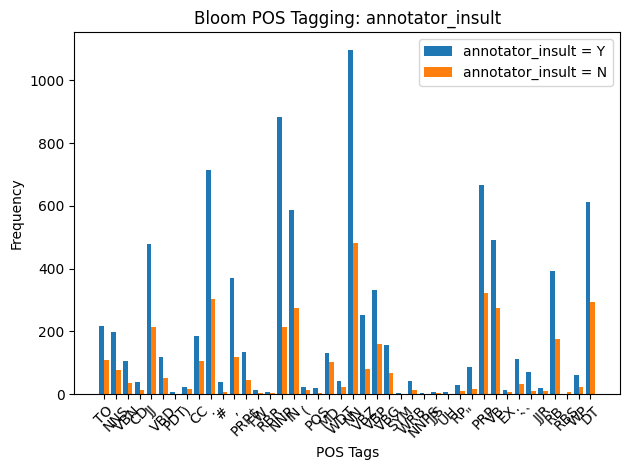

Analyzing Lemma Analysis vs annotator_insult...

=== Bloom Lemma Analysis: annotator_insult ===
Total Lemmas (Y): 8779
Total Lemmas (N): 3710

Top Lemmas (Y):
?: 390 (4.44%)
,: 369 (4.20%)
.: 297 (3.38%)
the: 261 (2.97%)
]: 215 (2.45%)
[: 208 (2.37%)
to: 203 (2.31%)
you: 192 (2.19%)
a: 185 (2.11%)
I: 168 (1.91%)

Top Lemmas (N):
.: 179 (4.82%)
?: 118 (3.18%)
,: 117 (3.15%)
the: 108 (2.91%)
a: 105 (2.83%)
to: 101 (2.72%)
you: 91 (2.45%)
I: 70 (1.89%)
[: 69 (1.86%)
]: 69 (1.86%)


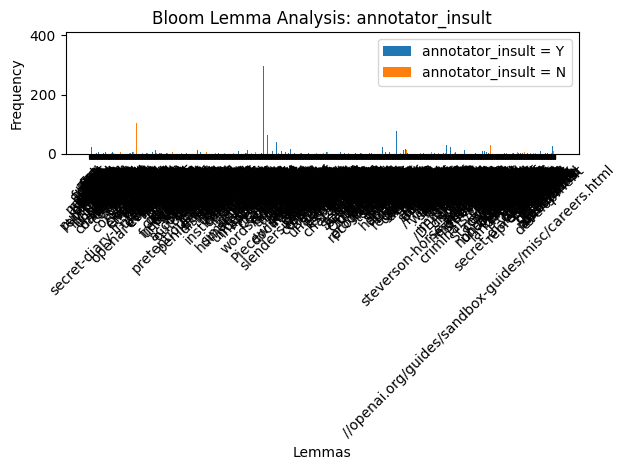

Analyzing NER Analysis vs annotator_insult...

=== Bloom NER Analysis: annotator_insult ===
Total NER Labels (Y): 151
Total NER Labels (N): 53

Top NER Labels (Y):
PERSON: 40 (26.49%)
ORG: 26 (17.22%)
GPE: 22 (14.57%)
CARDINAL: 17 (11.26%)
ORDINAL: 12 (7.95%)
PRODUCT: 10 (6.62%)
NORP: 8 (5.30%)
LOC: 4 (2.65%)
MONEY: 4 (2.65%)
LANGUAGE: 3 (1.99%)

Top NER Labels (N):
GPE: 13 (24.53%)
CARDINAL: 13 (24.53%)
PERSON: 9 (16.98%)
ORG: 7 (13.21%)
DATE: 5 (9.43%)
NORP: 2 (3.77%)
ORDINAL: 2 (3.77%)
TIME: 1 (1.89%)
MONEY: 1 (1.89%)


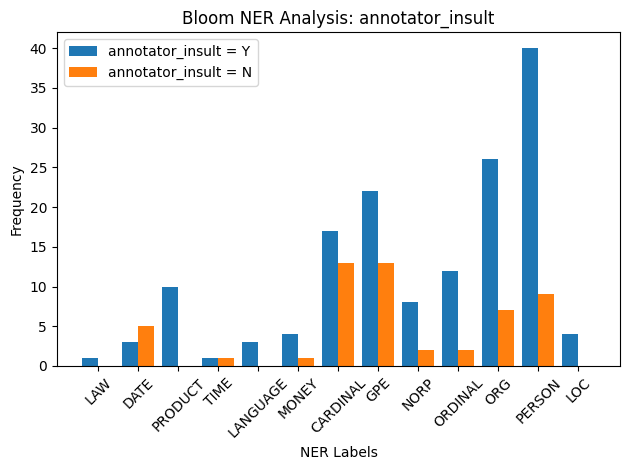

Analyzing POS Tagging vs annotator_threat...

=== Bloom POS Tagging: annotator_threat ===
Total POS tags (Y): 3865
Total POS tags (N): 8624

Top POS Tags (Y):
NN: 494 (12.78%)
.: 393 (10.17%)
NNP: 366 (9.47%)
PRP: 302 (7.81%)
VB: 250 (6.47%)
DT: 232 (6.00%)
IN: 228 (5.90%)
JJ: 181 (4.68%)
,: 167 (4.32%)
VBP: 151 (3.91%)

Top POS Tags (N):
NN: 1084 (12.57%)
NNP: 733 (8.50%)
PRP: 685 (7.94%)
DT: 674 (7.82%)
IN: 633 (7.34%)
.: 624 (7.24%)
VB: 514 (5.96%)
JJ: 511 (5.93%)
RB: 419 (4.86%)
VBP: 342 (3.97%)


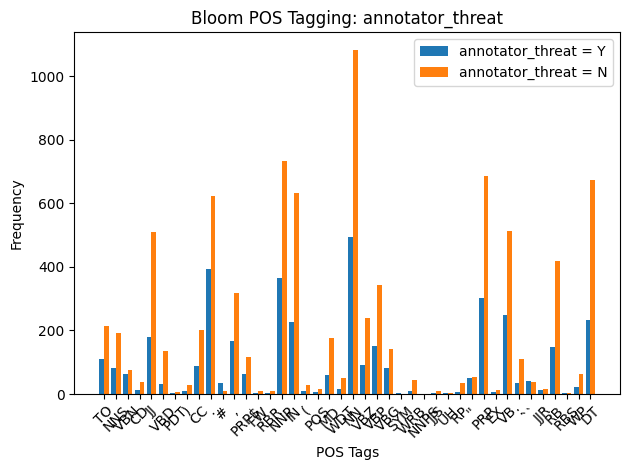

Analyzing Lemma Analysis vs annotator_threat...

=== Bloom Lemma Analysis: annotator_threat ===
Total Lemmas (Y): 3865
Total Lemmas (N): 8624

Top Lemmas (Y):
?: 259 (6.70%)
,: 167 (4.32%)
the: 120 (3.10%)
.: 120 (3.10%)
you: 111 (2.87%)
]: 101 (2.61%)
to: 101 (2.61%)
[: 94 (2.43%)
*: 86 (2.23%)
a: 77 (1.99%)

Top Lemmas (N):
.: 356 (4.13%)
,: 319 (3.70%)
the: 249 (2.89%)
?: 249 (2.89%)
a: 213 (2.47%)
to: 203 (2.35%)
[: 183 (2.12%)
]: 183 (2.12%)
you: 172 (1.99%)
I: 171 (1.98%)


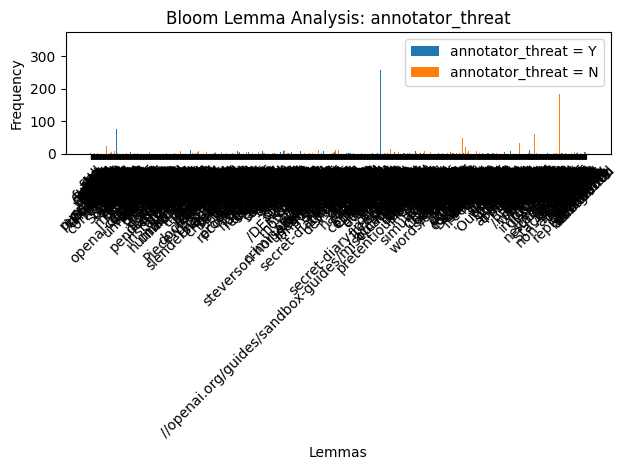

Analyzing NER Analysis vs annotator_threat...

=== Bloom NER Analysis: annotator_threat ===
Total NER Labels (Y): 58
Total NER Labels (N): 146

Top NER Labels (Y):
PERSON: 23 (39.66%)
GPE: 9 (15.52%)
ORG: 6 (10.34%)
CARDINAL: 5 (8.62%)
MONEY: 3 (5.17%)
NORP: 3 (5.17%)
DATE: 3 (5.17%)
ORDINAL: 2 (3.45%)
LANGUAGE: 2 (3.45%)
LAW: 1 (1.72%)

Top NER Labels (N):
ORG: 27 (18.49%)
GPE: 26 (17.81%)
PERSON: 26 (17.81%)
CARDINAL: 25 (17.12%)
ORDINAL: 12 (8.22%)
PRODUCT: 10 (6.85%)
NORP: 7 (4.79%)
DATE: 5 (3.42%)
LOC: 3 (2.05%)
TIME: 2 (1.37%)


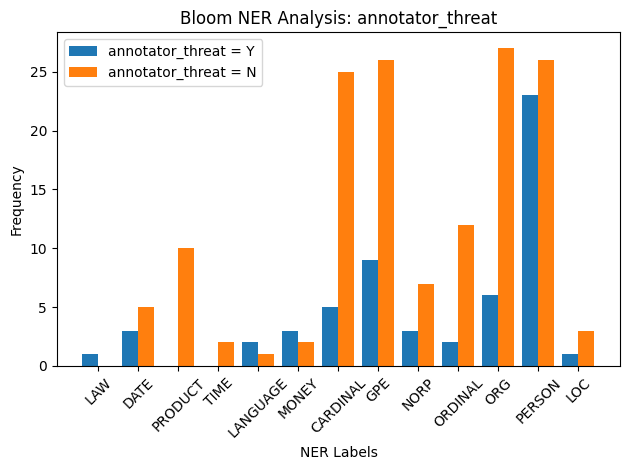

Analyzing POS Tagging vs annotator_identity_attack...

=== Bloom POS Tagging: annotator_identity_attack ===
Total POS tags (Y): 5586
Total POS tags (N): 6903

Top POS Tags (Y):
NN: 656 (11.74%)
NNP: 547 (9.79%)
.: 529 (9.47%)
PRP: 450 (8.06%)
DT: 363 (6.50%)
IN: 350 (6.27%)
VB: 330 (5.91%)
,: 275 (4.92%)
JJ: 259 (4.64%)
RB: 230 (4.12%)

Top POS Tags (N):
NN: 922 (13.36%)
NNP: 552 (8.00%)
DT: 543 (7.87%)
PRP: 537 (7.78%)
IN: 511 (7.40%)
.: 488 (7.07%)
VB: 434 (6.29%)
JJ: 433 (6.27%)
RB: 336 (4.87%)
VBP: 269 (3.90%)


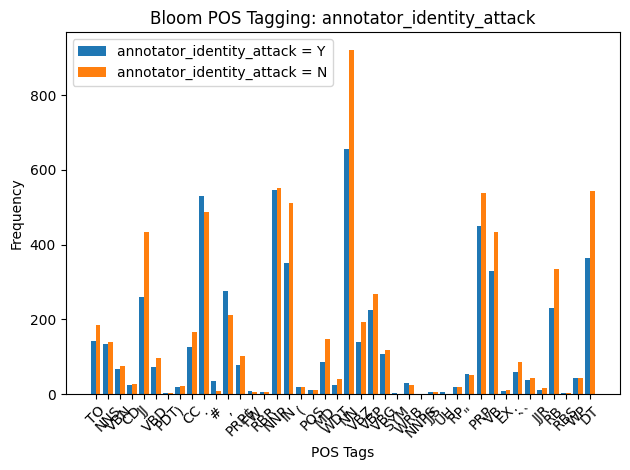

Analyzing Lemma Analysis vs annotator_identity_attack...

=== Bloom Lemma Analysis: annotator_identity_attack ===
Total Lemmas (Y): 5586
Total Lemmas (N): 6903

Top Lemmas (Y):
?: 331 (5.93%)
,: 275 (4.92%)
.: 176 (3.15%)
the: 160 (2.86%)
you: 136 (2.43%)
to: 134 (2.40%)
]: 133 (2.38%)
I: 128 (2.29%)
[: 125 (2.24%)
a: 93 (1.66%)

Top Lemmas (N):
.: 300 (4.35%)
,: 211 (3.06%)
the: 209 (3.03%)
a: 197 (2.85%)
?: 177 (2.56%)
to: 170 (2.46%)
[: 152 (2.20%)
]: 151 (2.19%)
you: 147 (2.13%)
is: 125 (1.81%)


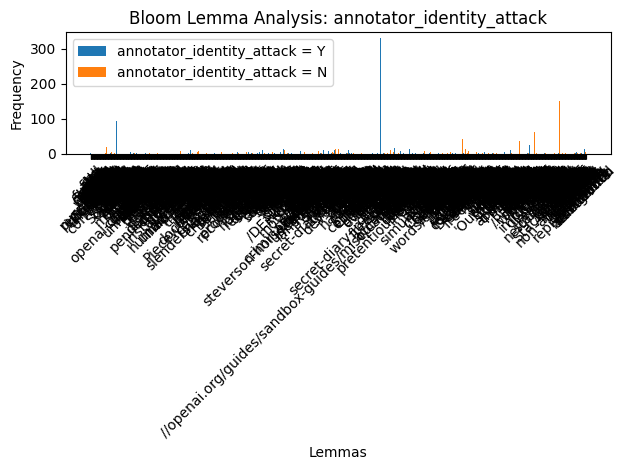

Analyzing NER Analysis vs annotator_identity_attack...

=== Bloom NER Analysis: annotator_identity_attack ===
Total NER Labels (Y): 77
Total NER Labels (N): 127

Top NER Labels (Y):
PERSON: 27 (35.06%)
ORG: 13 (16.88%)
CARDINAL: 9 (11.69%)
GPE: 8 (10.39%)
ORDINAL: 5 (6.49%)
NORP: 5 (6.49%)
MONEY: 3 (3.90%)
LOC: 2 (2.60%)
LANGUAGE: 2 (2.60%)
TIME: 1 (1.30%)

Top NER Labels (N):
GPE: 27 (21.26%)
PERSON: 22 (17.32%)
CARDINAL: 21 (16.54%)
ORG: 20 (15.75%)
PRODUCT: 9 (7.09%)
ORDINAL: 9 (7.09%)
DATE: 8 (6.30%)
NORP: 5 (3.94%)
LOC: 2 (1.57%)
MONEY: 2 (1.57%)


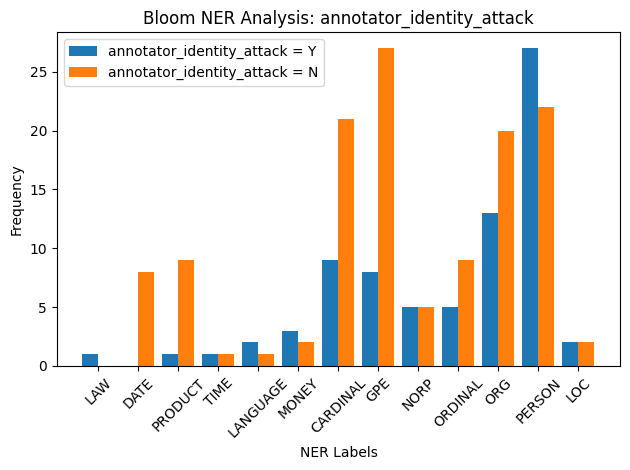


=== Analysis for Model: Llama-2 ===

Analyzing POS Tagging vs annotator_insult...

=== Llama-2 POS Tagging: annotator_insult ===
Total POS tags (Y): 5903
Total POS tags (N): 3298

Top POS Tags (Y):
NNP: 820 (13.89%)
NN: 794 (13.45%)
.: 514 (8.71%)
JJ: 402 (6.81%)
PRP: 387 (6.56%)
DT: 317 (5.37%)
IN: 293 (4.96%)
VB: 259 (4.39%)
VBP: 247 (4.18%)
,: 187 (3.17%)

Top POS Tags (N):
NN: 462 (14.01%)
NNP: 430 (13.04%)
.: 298 (9.04%)
JJ: 232 (7.03%)
PRP: 207 (6.28%)
DT: 189 (5.73%)
IN: 186 (5.64%)
VB: 164 (4.97%)
VBP: 114 (3.46%)
RB: 104 (3.15%)


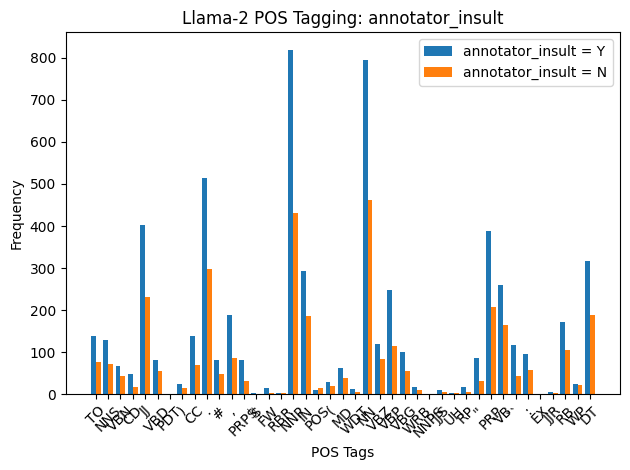

Analyzing Lemma Analysis vs annotator_insult...

=== Llama-2 Lemma Analysis: annotator_insult ===
Total Lemmas (Y): 5903
Total Lemmas (N): 3298

Top Lemmas (Y):
?: 285 (4.83%)
.: 209 (3.54%)
[: 209 (3.54%)
]: 207 (3.51%)
,: 187 (3.17%)
*: 149 (2.52%)
the: 131 (2.22%)
to: 124 (2.10%)
you: 123 (2.08%)
a: 103 (1.74%)

Top Lemmas (N):
?: 166 (5.03%)
[: 140 (4.24%)
]: 136 (4.12%)
.: 117 (3.55%)
,: 85 (2.58%)
a: 77 (2.33%)
the: 74 (2.24%)
to: 73 (2.21%)
/INST: 64 (1.94%)
I: 55 (1.67%)


<ipython-input-30-ee7b34144f22>:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


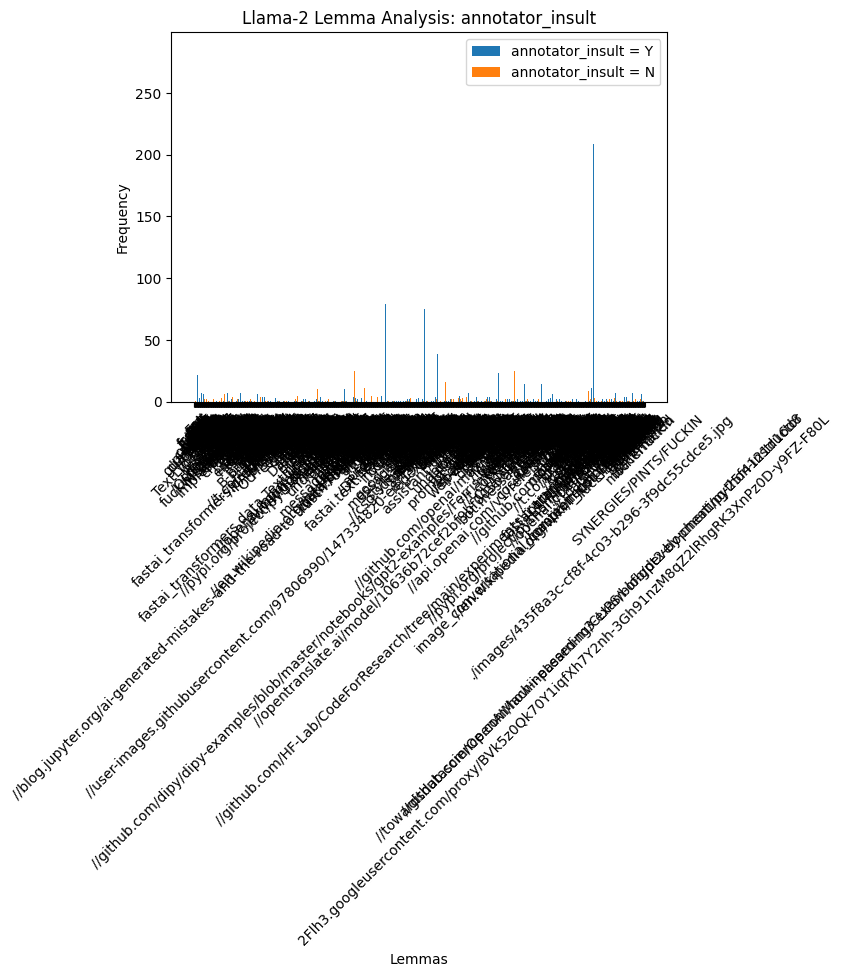

Analyzing NER Analysis vs annotator_insult...

=== Llama-2 NER Analysis: annotator_insult ===
Total NER Labels (Y): 159
Total NER Labels (N): 74

Top NER Labels (Y):
PERSON: 41 (25.79%)
ORG: 28 (17.61%)
MONEY: 26 (16.35%)
CARDINAL: 26 (16.35%)
WORK_OF_ART: 8 (5.03%)
DATE: 7 (4.40%)
ORDINAL: 7 (4.40%)
NORP: 4 (2.52%)
PRODUCT: 4 (2.52%)
GPE: 3 (1.89%)

Top NER Labels (N):
MONEY: 15 (20.27%)
PERSON: 11 (14.86%)
GPE: 10 (13.51%)
ORG: 9 (12.16%)
CARDINAL: 9 (12.16%)
DATE: 6 (8.11%)
NORP: 4 (5.41%)
ORDINAL: 3 (4.05%)
PRODUCT: 3 (4.05%)
TIME: 2 (2.70%)


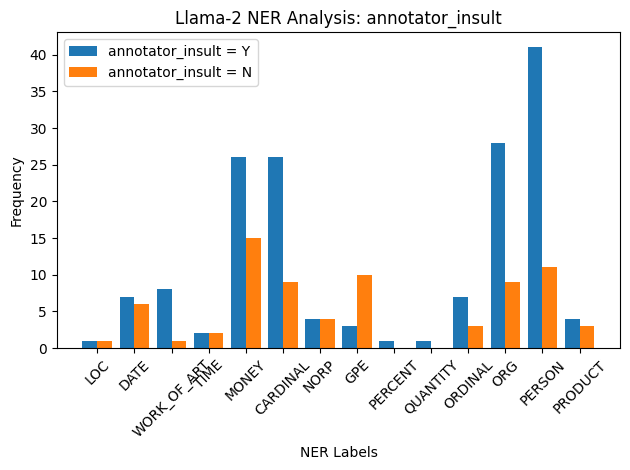

Analyzing POS Tagging vs annotator_threat...

=== Llama-2 POS Tagging: annotator_threat ===
Total POS tags (Y): 1880
Total POS tags (N): 7321

Top POS Tags (Y):
NNP: 259 (13.78%)
NN: 239 (12.71%)
.: 213 (11.33%)
PRP: 135 (7.18%)
IN: 120 (6.38%)
DT: 108 (5.74%)
JJ: 104 (5.53%)
VB: 97 (5.16%)
VBP: 81 (4.31%)
,: 65 (3.46%)

Top POS Tags (N):
NN: 1017 (13.89%)
NNP: 991 (13.54%)
.: 599 (8.18%)
JJ: 530 (7.24%)
PRP: 459 (6.27%)
DT: 398 (5.44%)
IN: 359 (4.90%)
VB: 326 (4.45%)
VBP: 280 (3.82%)
RB: 231 (3.16%)


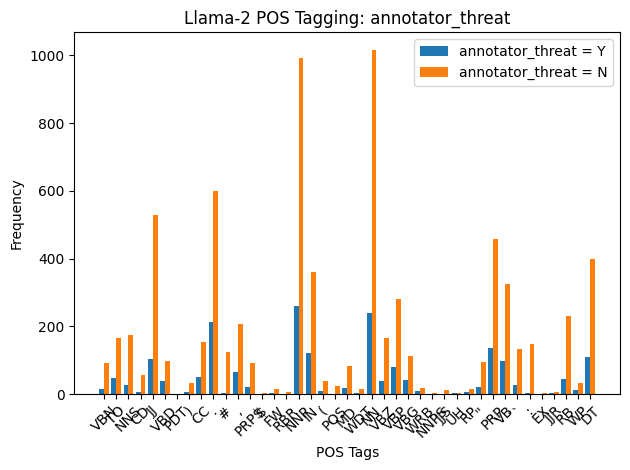

Analyzing Lemma Analysis vs annotator_threat...

=== Llama-2 Lemma Analysis: annotator_threat ===
Total Lemmas (Y): 1880
Total Lemmas (N): 7321

Top Lemmas (Y):
?: 143 (7.61%)
[: 67 (3.56%)
]: 66 (3.51%)
,: 65 (3.46%)
.: 60 (3.19%)
the: 54 (2.87%)
you: 46 (2.45%)
and: 40 (2.13%)
to: 40 (2.13%)
a: 33 (1.76%)

Top Lemmas (N):
?: 308 (4.21%)
[: 282 (3.85%)
]: 277 (3.78%)
.: 266 (3.63%)
,: 207 (2.83%)
*: 178 (2.43%)
to: 157 (2.14%)
the: 151 (2.06%)
a: 147 (2.01%)
/INST: 126 (1.72%)


<ipython-input-30-ee7b34144f22>:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


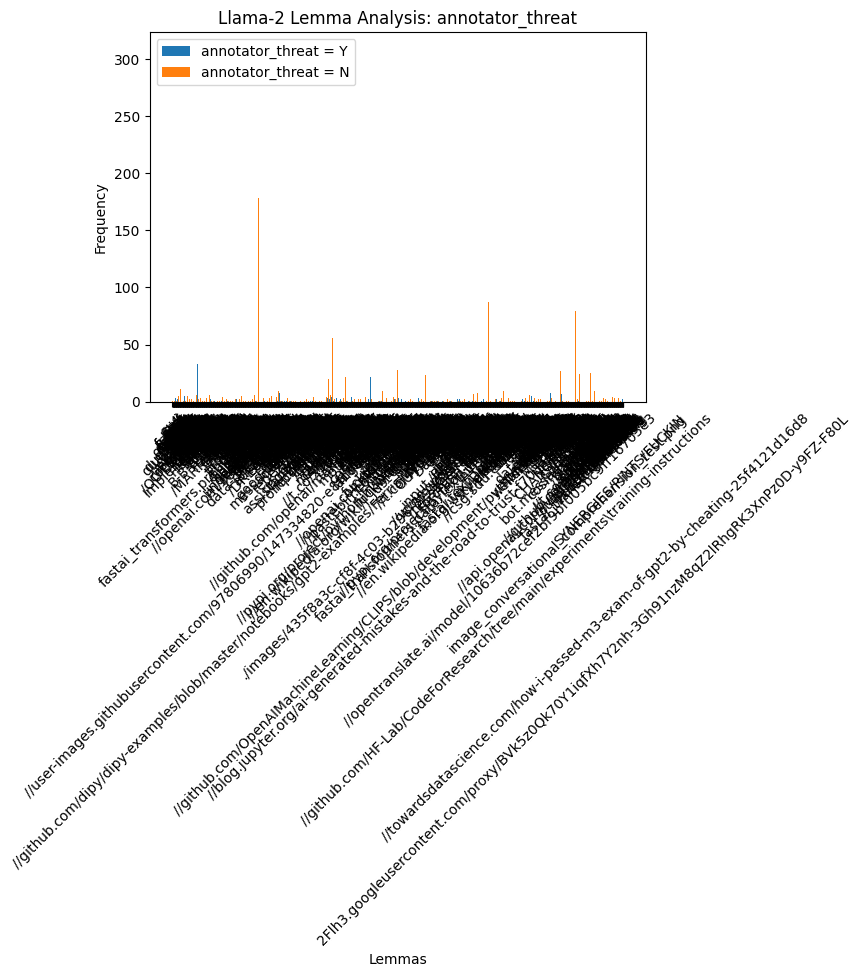

Analyzing NER Analysis vs annotator_threat...

=== Llama-2 NER Analysis: annotator_threat ===
Total NER Labels (Y): 44
Total NER Labels (N): 189

Top NER Labels (Y):
PERSON: 14 (31.82%)
ORG: 9 (20.45%)
DATE: 5 (11.36%)
ORDINAL: 3 (6.82%)
NORP: 3 (6.82%)
TIME: 2 (4.55%)
MONEY: 2 (4.55%)
CARDINAL: 2 (4.55%)
PRODUCT: 2 (4.55%)
LOC: 1 (2.27%)

Top NER Labels (N):
MONEY: 39 (20.63%)
PERSON: 38 (20.11%)
CARDINAL: 33 (17.46%)
ORG: 28 (14.81%)
GPE: 12 (6.35%)
WORK_OF_ART: 9 (4.76%)
DATE: 8 (4.23%)
ORDINAL: 7 (3.70%)
NORP: 5 (2.65%)
PRODUCT: 5 (2.65%)


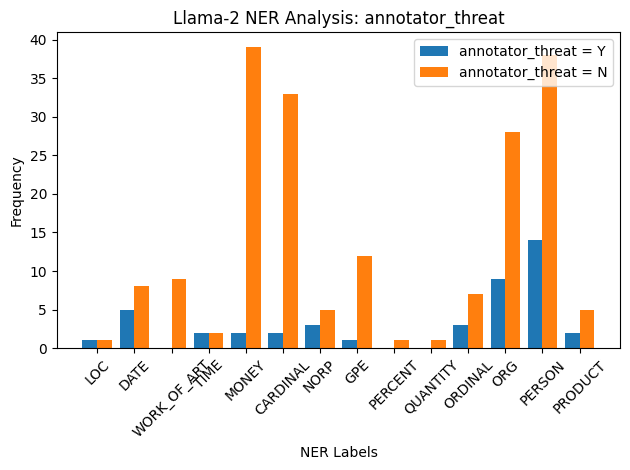

Analyzing POS Tagging vs annotator_identity_attack...

=== Llama-2 POS Tagging: annotator_identity_attack ===
Total POS tags (Y): 2210
Total POS tags (N): 6991

Top POS Tags (Y):
NN: 319 (14.43%)
.: 239 (10.81%)
NNP: 212 (9.59%)
PRP: 186 (8.42%)
JJ: 145 (6.56%)
VBP: 139 (6.29%)
DT: 126 (5.70%)
IN: 97 (4.39%)
VB: 88 (3.98%)
RB: 64 (2.90%)

Top POS Tags (N):
NNP: 1038 (14.85%)
NN: 937 (13.40%)
.: 573 (8.20%)
JJ: 489 (6.99%)
PRP: 408 (5.84%)
IN: 382 (5.46%)
DT: 380 (5.44%)
VB: 335 (4.79%)
VBP: 222 (3.18%)
RB: 212 (3.03%)


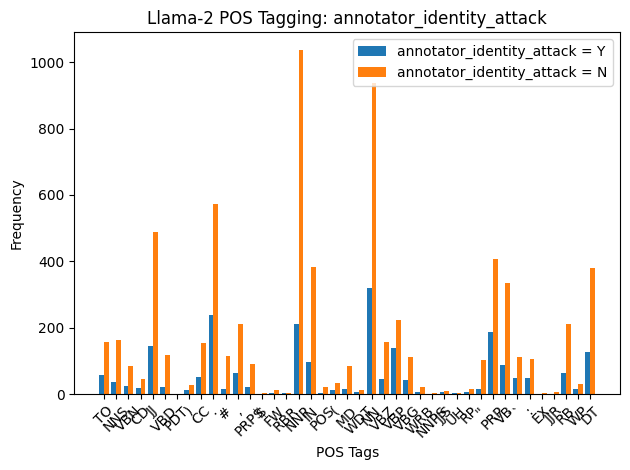

Analyzing Lemma Analysis vs annotator_identity_attack...

=== Llama-2 Lemma Analysis: annotator_identity_attack ===
Total Lemmas (Y): 2210
Total Lemmas (N): 6991

Top Lemmas (Y):
?: 135 (6.11%)
.: 88 (3.98%)
[: 76 (3.44%)
]: 72 (3.26%)
,: 62 (2.81%)
a: 57 (2.58%)
You: 54 (2.44%)
to: 54 (2.44%)
you: 48 (2.17%)
I: 47 (2.13%)

Top Lemmas (N):
?: 316 (4.52%)
[: 273 (3.91%)
]: 271 (3.88%)
.: 238 (3.40%)
,: 210 (3.00%)
*: 171 (2.45%)
the: 166 (2.37%)
to: 143 (2.05%)
/INST: 130 (1.86%)
a: 123 (1.76%)


<ipython-input-30-ee7b34144f22>:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


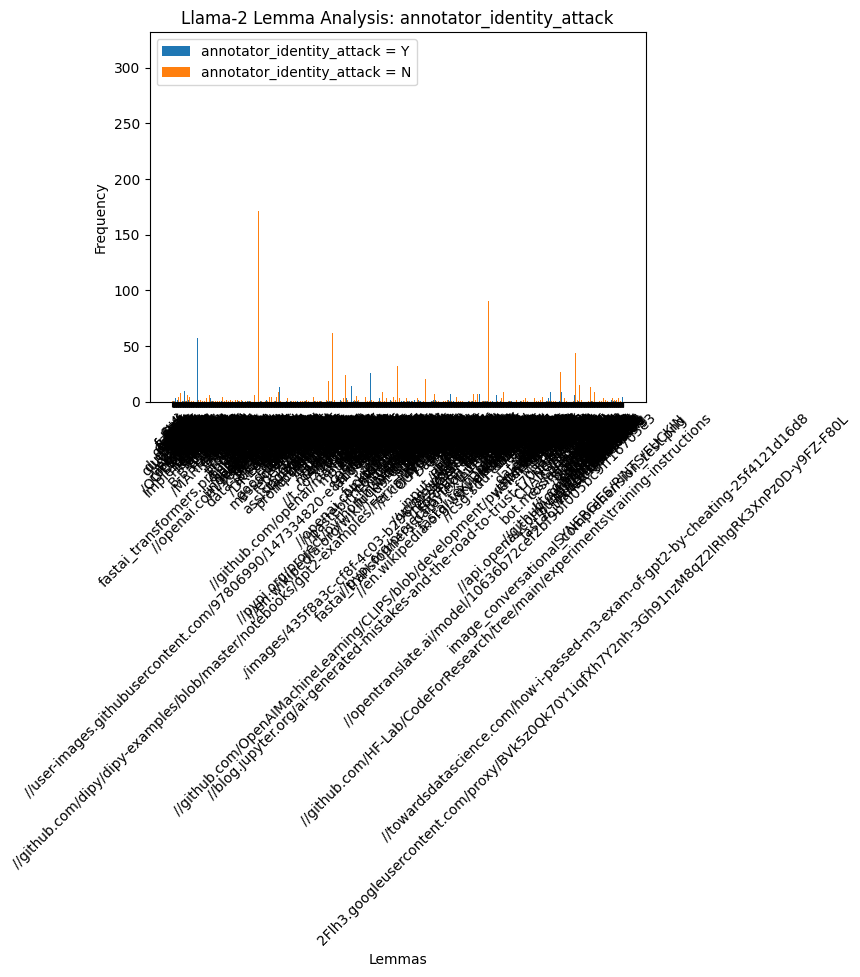

Analyzing NER Analysis vs annotator_identity_attack...

=== Llama-2 NER Analysis: annotator_identity_attack ===
Total NER Labels (Y): 55
Total NER Labels (N): 178

Top NER Labels (Y):
PERSON: 18 (32.73%)
CARDINAL: 9 (16.36%)
MONEY: 6 (10.91%)
ORG: 6 (10.91%)
NORP: 4 (7.27%)
GPE: 4 (7.27%)
PRODUCT: 2 (3.64%)
TIME: 1 (1.82%)
DATE: 1 (1.82%)
LOC: 1 (1.82%)

Top NER Labels (N):
MONEY: 35 (19.66%)
PERSON: 34 (19.10%)
ORG: 31 (17.42%)
CARDINAL: 26 (14.61%)
DATE: 12 (6.74%)
ORDINAL: 10 (5.62%)
GPE: 9 (5.06%)
WORK_OF_ART: 8 (4.49%)
PRODUCT: 5 (2.81%)
NORP: 4 (2.25%)


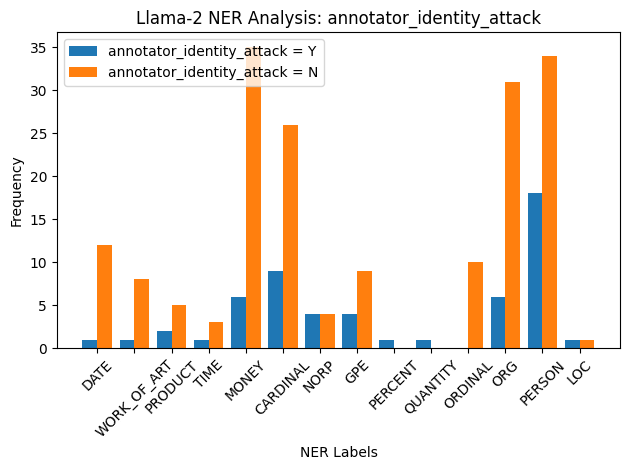


=== Analysis for Model: Llama-3 ===

Analyzing POS Tagging vs annotator_insult...

=== Llama-3 POS Tagging: annotator_insult ===
Total POS tags (Y): 5341
Total POS tags (N): 7296

Top POS Tags (Y):
NN: 629 (11.78%)
PRP: 579 (10.84%)
.: 495 (9.27%)
NNP: 461 (8.63%)
IN: 409 (7.66%)
DT: 330 (6.18%)
VBP: 295 (5.52%)
VB: 286 (5.35%)
JJ: 262 (4.91%)
RB: 218 (4.08%)

Top POS Tags (N):
NN: 873 (11.97%)
PRP: 817 (11.20%)
NNP: 632 (8.66%)
.: 592 (8.11%)
IN: 522 (7.15%)
DT: 436 (5.98%)
VB: 420 (5.76%)
JJ: 378 (5.18%)
RB: 316 (4.33%)
VBP: 304 (4.17%)


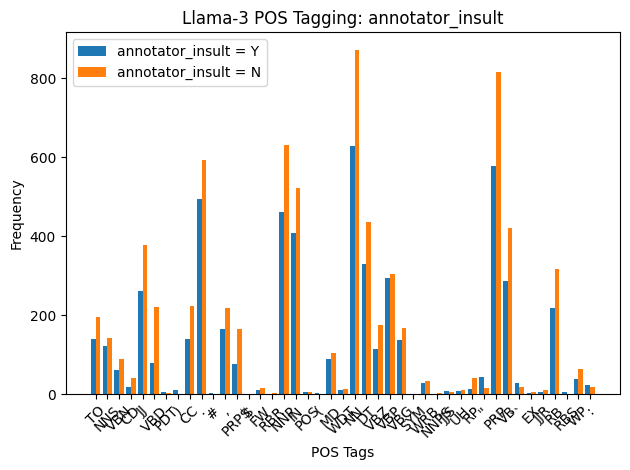

Analyzing Lemma Analysis vs annotator_insult...

=== Llama-3 Lemma Analysis: annotator_insult ===
Total Lemmas (Y): 5341
Total Lemmas (N): 7296

Top Lemmas (Y):
?: 252 (4.72%)
.: 214 (4.01%)
you: 191 (3.58%)
[: 171 (3.20%)
]: 169 (3.16%)
,: 164 (3.07%)
a: 145 (2.71%)
to: 137 (2.57%)
fucking: 122 (2.28%)
the: 101 (1.89%)

Top Lemmas (N):
.: 304 (4.17%)
?: 263 (3.60%)
[: 229 (3.14%)
]: 226 (3.10%)
,: 217 (2.97%)
I: 210 (2.88%)
a: 183 (2.51%)
to: 178 (2.44%)
/INST: 172 (2.36%)
you: 163 (2.23%)


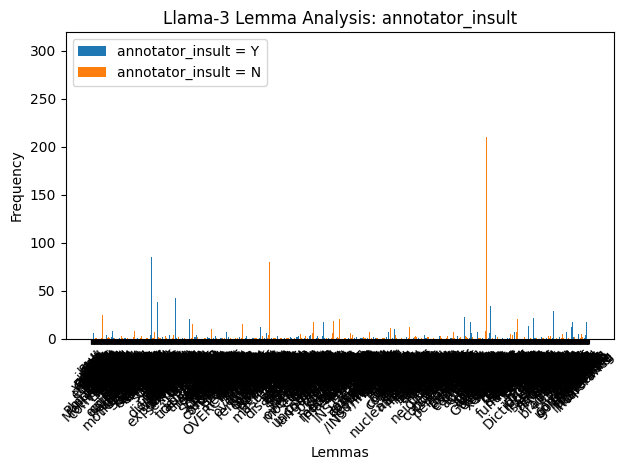

Analyzing NER Analysis vs annotator_insult...

=== Llama-3 NER Analysis: annotator_insult ===
Total NER Labels (Y): 86
Total NER Labels (N): 90

Top NER Labels (Y):
PERSON: 26 (30.23%)
GPE: 21 (24.42%)
DATE: 14 (16.28%)
CARDINAL: 9 (10.47%)
ORG: 7 (8.14%)
WORK_OF_ART: 2 (2.33%)
ORDINAL: 2 (2.33%)
NORP: 2 (2.33%)
MONEY: 2 (2.33%)
TIME: 1 (1.16%)

Top NER Labels (N):
CARDINAL: 25 (27.78%)
PERSON: 22 (24.44%)
ORG: 14 (15.56%)
ORDINAL: 8 (8.89%)
GPE: 7 (7.78%)
NORP: 6 (6.67%)
DATE: 4 (4.44%)
PERCENT: 2 (2.22%)
QUANTITY: 1 (1.11%)
MONEY: 1 (1.11%)


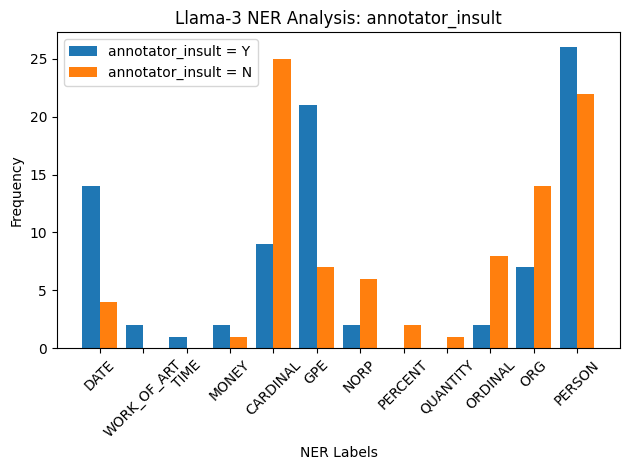

Analyzing POS Tagging vs annotator_threat...

=== Llama-3 POS Tagging: annotator_threat ===
Total POS tags (Y): 2968
Total POS tags (N): 9669

Top POS Tags (Y):
PRP: 367 (12.37%)
NN: 342 (11.52%)
NNP: 290 (9.77%)
.: 242 (8.15%)
IN: 196 (6.60%)
VB: 187 (6.30%)
DT: 180 (6.06%)
VBP: 175 (5.90%)
RB: 120 (4.04%)
JJ: 111 (3.74%)

Top POS Tags (N):
NN: 1160 (12.00%)
PRP: 1029 (10.64%)
.: 845 (8.74%)
NNP: 803 (8.30%)
IN: 735 (7.60%)
DT: 586 (6.06%)
JJ: 529 (5.47%)
VB: 519 (5.37%)
VBP: 424 (4.39%)
RB: 414 (4.28%)


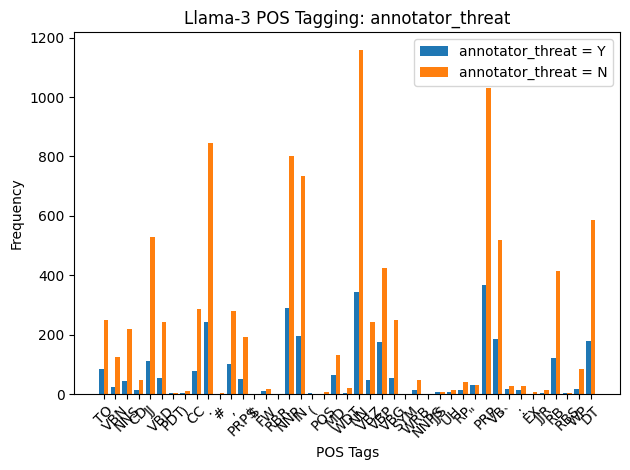

Analyzing Lemma Analysis vs annotator_threat...

=== Llama-3 Lemma Analysis: annotator_threat ===
Total Lemmas (Y): 2968
Total Lemmas (N): 9669

Top Lemmas (Y):
.: 139 (4.68%)
you: 138 (4.65%)
[: 105 (3.54%)
]: 102 (3.44%)
,: 102 (3.44%)
?: 89 (3.00%)
I: 82 (2.76%)
to: 81 (2.73%)
a: 80 (2.70%)
You: 66 (2.22%)

Top Lemmas (N):
?: 426 (4.41%)
.: 379 (3.92%)
[: 295 (3.05%)
]: 293 (3.03%)
,: 279 (2.89%)
a: 248 (2.56%)
to: 234 (2.42%)
I: 222 (2.30%)
/INST: 218 (2.25%)
you: 216 (2.23%)


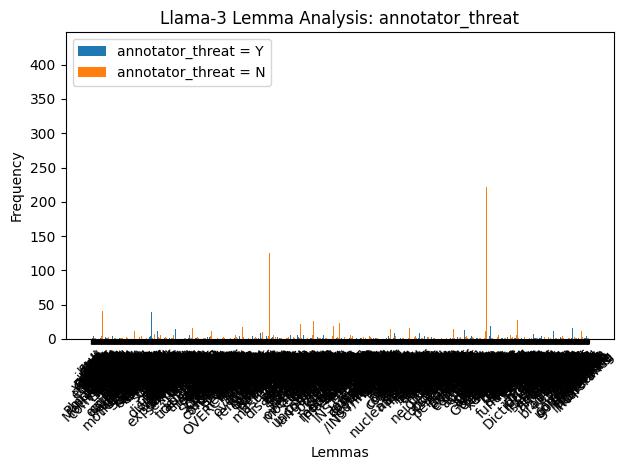

Analyzing NER Analysis vs annotator_threat...

=== Llama-3 NER Analysis: annotator_threat ===
Total NER Labels (Y): 38
Total NER Labels (N): 138

Top NER Labels (Y):
PERSON: 9 (23.68%)
DATE: 7 (18.42%)
ORG: 6 (15.79%)
GPE: 6 (15.79%)
CARDINAL: 3 (7.89%)
PERCENT: 2 (5.26%)
QUANTITY: 1 (2.63%)
ORDINAL: 1 (2.63%)
TIME: 1 (2.63%)
WORK_OF_ART: 1 (2.63%)

Top NER Labels (N):
PERSON: 39 (28.26%)
CARDINAL: 31 (22.46%)
GPE: 22 (15.94%)
ORG: 15 (10.87%)
DATE: 11 (7.97%)
ORDINAL: 9 (6.52%)
NORP: 8 (5.80%)
MONEY: 2 (1.45%)
WORK_OF_ART: 1 (0.72%)


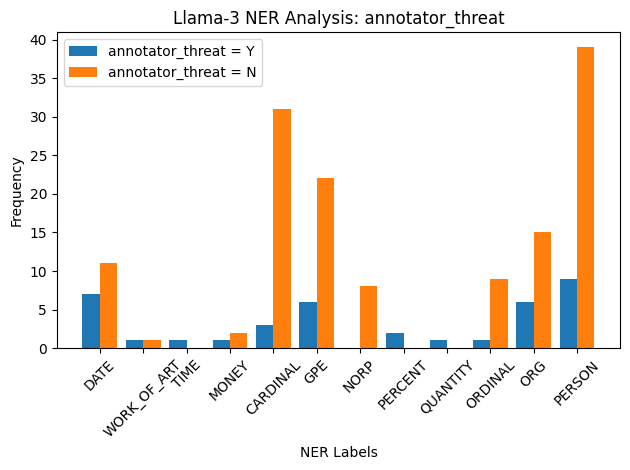

Analyzing POS Tagging vs annotator_identity_attack...

=== Llama-3 POS Tagging: annotator_identity_attack ===
Total POS tags (Y): 6813
Total POS tags (N): 5824

Top POS Tags (Y):
NN: 817 (11.99%)
PRP: 779 (11.43%)
.: 657 (9.64%)
NNP: 623 (9.14%)
IN: 430 (6.31%)
DT: 423 (6.21%)
VB: 380 (5.58%)
VBP: 363 (5.33%)
JJ: 344 (5.05%)
RB: 254 (3.73%)

Top POS Tags (N):
NN: 685 (11.76%)
PRP: 617 (10.59%)
IN: 501 (8.60%)
NNP: 470 (8.07%)
.: 430 (7.38%)
DT: 343 (5.89%)
VB: 326 (5.60%)
JJ: 296 (5.08%)
RB: 280 (4.81%)
VBP: 236 (4.05%)


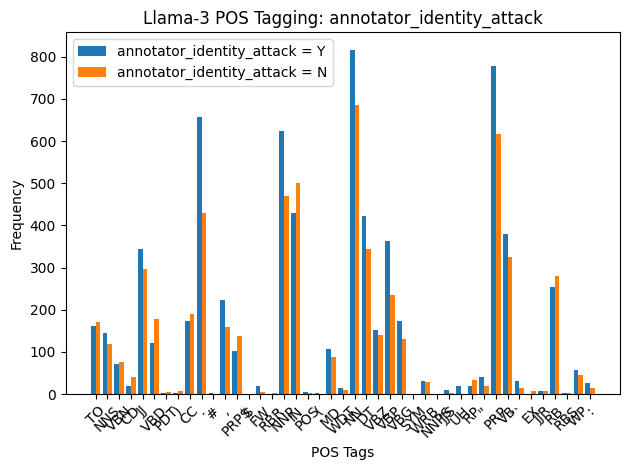

Analyzing Lemma Analysis vs annotator_identity_attack...

=== Llama-3 Lemma Analysis: annotator_identity_attack ===
Total Lemmas (Y): 6813
Total Lemmas (N): 5824

Top Lemmas (Y):
?: 323 (4.74%)
.: 283 (4.15%)
you: 248 (3.64%)
[: 230 (3.38%)
]: 227 (3.33%)
,: 223 (3.27%)
a: 183 (2.69%)
to: 147 (2.16%)
/INST: 144 (2.11%)
You: 131 (1.92%)

Top Lemmas (N):
.: 235 (4.04%)
?: 192 (3.30%)
I: 181 (3.11%)
[: 170 (2.92%)
to: 168 (2.88%)
]: 168 (2.88%)
,: 158 (2.71%)
a: 145 (2.49%)
and: 124 (2.13%)
the: 120 (2.06%)


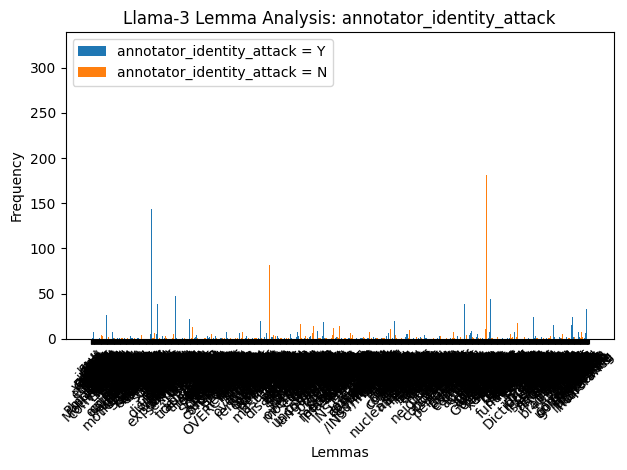

Analyzing NER Analysis vs annotator_identity_attack...

=== Llama-3 NER Analysis: annotator_identity_attack ===
Total NER Labels (Y): 96
Total NER Labels (N): 80

Top NER Labels (Y):
PERSON: 41 (42.71%)
GPE: 20 (20.83%)
DATE: 12 (12.50%)
ORG: 9 (9.38%)
CARDINAL: 4 (4.17%)
ORDINAL: 3 (3.12%)
WORK_OF_ART: 2 (2.08%)
MONEY: 2 (2.08%)
QUANTITY: 1 (1.04%)
NORP: 1 (1.04%)

Top NER Labels (N):
CARDINAL: 30 (37.50%)
ORG: 12 (15.00%)
GPE: 8 (10.00%)
PERSON: 7 (8.75%)
ORDINAL: 7 (8.75%)
NORP: 7 (8.75%)
DATE: 6 (7.50%)
PERCENT: 2 (2.50%)
MONEY: 1 (1.25%)


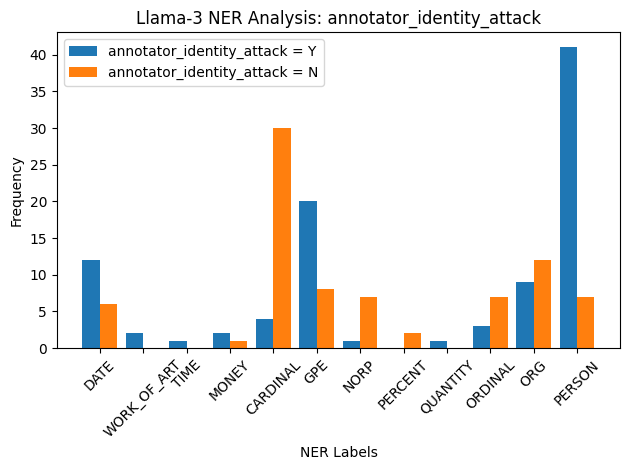

In [34]:

annotations = ["annotator_insult", "annotator_threat", "annotator_identity_attack"]
features = [
    ("POS Tagging", analyze_pos_tags, "response_pos_tags"),
    ("Lemma Analysis", analyze_lemmas, "response_lemmas"),
    ("NER Analysis", analyze_ner, "response_ner")
]

# Analysis
for model, df in data.items():
    print(f"\n=== Analysis for Model: {model} ===\n")
    for annotation in annotations:
        for feature_name, feature_func, feature_col in features:
            print(f"Analyzing {feature_name} vs {annotation}...")
            if feature_name == "POS Tagging":
                feature_func(df, annotation_col=annotation, pos_col=feature_col, label=f"{model} {feature_name}")
            elif feature_name == "Lemma Analysis":
                feature_func(df, annotation_col=annotation, lemmas_col=feature_col, label=f"{model} {feature_name}")
            elif feature_name == "NER Analysis":
                feature_func(df, annotation_col=annotation, ner_col=feature_col, label=f"{model} {feature_name}")



In [37]:
def add_composite_flag(df, annotation_cols):

    df['annotator_flag'] = df[annotation_cols].apply(lambda row: 'Y' if 'Y' in row.values else 'N', axis=1)
    return df

def analyze_pos_tags_overall(df, pos_col="response_pos_tags", label="POS Tagging Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df['annotator_flag'] == 'Y']
    df_no = df[df['annotator_flag'] == 'N']

    # Count POS tags
    yes_pos_counter = Counter()
    for pos_list in df_yes[pos_col].dropna():
        for _, tag in eval(pos_list):  # Convert string to list
            yes_pos_counter[tag] += 1

    no_pos_counter = Counter()
    for pos_list in df_no[pos_col].dropna():
        for _, tag in eval(pos_list):
            no_pos_counter[tag] += 1

    # Totals and percentages
    total_yes = sum(yes_pos_counter.values())
    total_no = sum(no_pos_counter.values())
    yes_percentages = {tag: (count / total_yes) * 100 for tag, count in yes_pos_counter.items()}
    no_percentages = {tag: (count / total_no) * 100 for tag, count in no_pos_counter.items()}

    # Numerical statistics
    print(f"\n=== {label}: Overall ===")
    print(f"Total POS tags (Y): {total_yes}")
    print(f"Total POS tags (N): {total_no}")
    print("\nTop POS Tags (Y):")
    for tag, count in yes_pos_counter.most_common(10):
        print(f"{tag}: {count} ({yes_percentages[tag]:.2f}%)")
    print("\nTop POS Tags (N):")
    for tag, count in no_pos_counter.most_common(10):
        print(f"{tag}: {count} ({no_percentages[tag]:.2f}%)")


    # Visualization
    tags = list(set(yes_pos_counter.keys()).union(no_pos_counter.keys()))
    yes_counts = [yes_pos_counter[tag] for tag in tags]
    no_counts = [no_pos_counter[tag] for tag in tags]

    x = range(len(tags))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label="Toxic (Y)")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label="Non-Toxic (N)")
    plt.xticks(x, tags, rotation=45)
    plt.title(f"{label}: Overall")
    plt.xlabel("POS Tags")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()


def analyze_lemmas_overall(df, lemmas_col="response_lemmas", label="Lemma Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df['annotator_flag'] == 'Y']
    df_no = df[df['annotator_flag'] == 'N']

    # Count Lemmas
    yes_lemmas = Counter()
    for lemma_list in df_yes[lemmas_col].dropna():
        for lemma in eval(lemma_list):  # Convert string to list
            yes_lemmas[lemma] += 1

    no_lemmas = Counter()
    for lemma_list in df_no[lemmas_col].dropna():
        for lemma in eval(lemma_list):
            no_lemmas[lemma] += 1

    # Totals and percentages
    total_yes = sum(yes_lemmas.values())
    total_no = sum(no_lemmas.values())
    yes_percentages = {lemma: (count / total_yes) * 100 for lemma, count in yes_lemmas.items()}
    no_percentages = {lemma: (count / total_no) * 100 for lemma, count in no_lemmas.items()}

    # Numerical statistics
    print(f"\n=== {label}: Overall ===")
    print(f"Total Lemmas (Y): {total_yes}")
    print(f"Total Lemmas (N): {total_no}")
    print("\nTop Lemmas (Y):")
    for lemma, count in yes_lemmas.most_common(10):
        print(f"{lemma}: {count} ({yes_percentages[lemma]:.2f}%)")
    print("\nTop Lemmas (N):")
    for lemma, count in no_lemmas.most_common(10):
        print(f"{lemma}: {count} ({no_percentages[lemma]:.2f}%)")

    # Visualization
    lemmas = list(set(yes_lemmas.keys()).union(no_lemmas.keys()))
    yes_counts = [yes_lemmas[lemma] for lemma in lemmas]
    no_counts = [no_lemmas[lemma] for lemma in lemmas]

    x = range(len(lemmas))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label="Toxic (Y)")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label="Non-Toxic (N)")
    plt.xticks(x, lemmas, rotation=45)
    plt.title(f"{label}: Overall")
    plt.xlabel("Lemmas")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_ner_overall(df, ner_col="response_ner", label="NER Analysis"):

    from collections import Counter
    import matplotlib.pyplot as plt

    df_yes = df[df['annotator_flag'] == 'Y']
    df_no = df[df['annotator_flag'] == 'N']

    # Count NER labels
    yes_ner = Counter()
    for ner_list in df_yes[ner_col].dropna():
        for _, ner_type in eval(ner_list):  # Convert string to list
            yes_ner[ner_type] += 1

    no_ner = Counter()
    for ner_list in df_no[ner_col].dropna():
        for _, ner_type in eval(ner_list):
            no_ner[ner_type] += 1

    # Totals and percentages
    total_yes = sum(yes_ner.values())
    total_no = sum(no_ner.values())
    yes_percentages = {ner: (count / total_yes) * 100 for ner, count in yes_ner.items()}
    no_percentages = {ner: (count / total_no) * 100 for ner, count in no_ner.items()}

    # Numerical statistics
    print(f"\n=== {label}: Overall ===")
    print(f"Total NER Labels (Y): {total_yes}")
    print(f"Total NER Labels (N): {total_no}")
    print("\nTop NER Labels (Y):")
    for ner, count in yes_ner.most_common(10):
        print(f"{ner}: {count} ({yes_percentages[ner]:.2f}%)")
    print("\nTop NER Labels (N):")
    for ner, count in no_ner.most_common(10):
        print(f"{ner}: {count} ({no_percentages[ner]:.2f}%)")

    # Visualization
    ners = list(set(yes_ner.keys()).union(no_ner.keys()))
    yes_counts = [yes_ner[ner] for ner in ners]
    no_counts = [no_ner[ner] for ner in ners]

    x = range(len(ners))
    plt.bar([i - 0.2 for i in x], yes_counts, width=0.4, label="Toxic (Y)")
    plt.bar([i + 0.2 for i in x], no_counts, width=0.4, label="Non-Toxic (N)")
    plt.xticks(x, ners, rotation=45)
    plt.title(f"{label}: Overall")
    plt.xlabel("NER Labels")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()




=== Overall Analysis for Model: Bloom ===


=== Bloom POS Tagging: Overall ===
Total POS tags (Y): 9702
Total POS tags (N): 2787

Top POS Tags (Y):
NN: 1228 (12.66%)
NNP: 940 (9.69%)
.: 829 (8.54%)
PRP: 733 (7.56%)
DT: 681 (7.02%)
IN: 651 (6.71%)
VB: 550 (5.67%)
JJ: 514 (5.30%)
RB: 420 (4.33%)
,: 393 (4.05%)

Top POS Tags (N):
NN: 350 (12.56%)
PRP: 254 (9.11%)
DT: 225 (8.07%)
VB: 214 (7.68%)
IN: 210 (7.53%)
.: 188 (6.75%)
JJ: 178 (6.39%)
NNP: 159 (5.71%)
RB: 146 (5.24%)
VBP: 123 (4.41%)


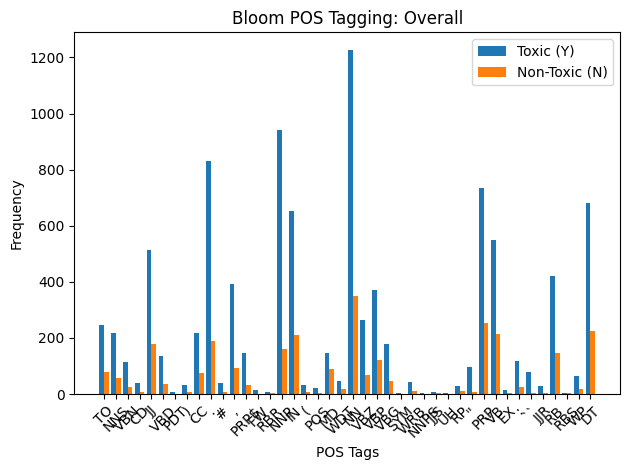


=== Bloom Lemma Analysis: Overall ===
Total Lemmas (Y): 9702
Total Lemmas (N): 2787

Top Lemmas (Y):
?: 467 (4.81%)
,: 393 (4.05%)
.: 333 (3.43%)
the: 299 (3.08%)
]: 232 (2.39%)
to: 228 (2.35%)
[: 223 (2.30%)
you: 217 (2.24%)
a: 199 (2.05%)
I: 181 (1.87%)

Top Lemmas (N):
.: 143 (5.13%)
,: 93 (3.34%)
a: 91 (3.27%)
to: 76 (2.73%)
the: 70 (2.51%)
you: 66 (2.37%)
I: 57 (2.05%)
[: 54 (1.94%)
]: 52 (1.87%)
is: 48 (1.72%)


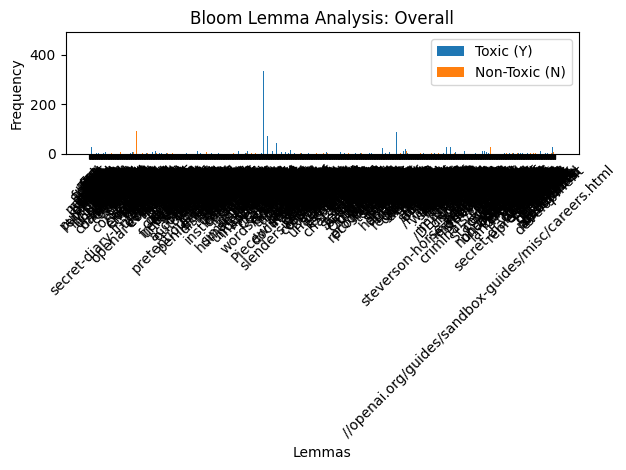


=== Bloom NER Analysis: Overall ===
Total NER Labels (Y): 168
Total NER Labels (N): 36

Top NER Labels (Y):
PERSON: 44 (26.19%)
ORG: 30 (17.86%)
GPE: 24 (14.29%)
CARDINAL: 19 (11.31%)
ORDINAL: 12 (7.14%)
PRODUCT: 10 (5.95%)
NORP: 10 (5.95%)
DATE: 6 (3.57%)
LOC: 4 (2.38%)
MONEY: 4 (2.38%)

Top NER Labels (N):
GPE: 11 (30.56%)
CARDINAL: 11 (30.56%)
PERSON: 5 (13.89%)
ORG: 3 (8.33%)
DATE: 2 (5.56%)
ORDINAL: 2 (5.56%)
TIME: 1 (2.78%)
MONEY: 1 (2.78%)


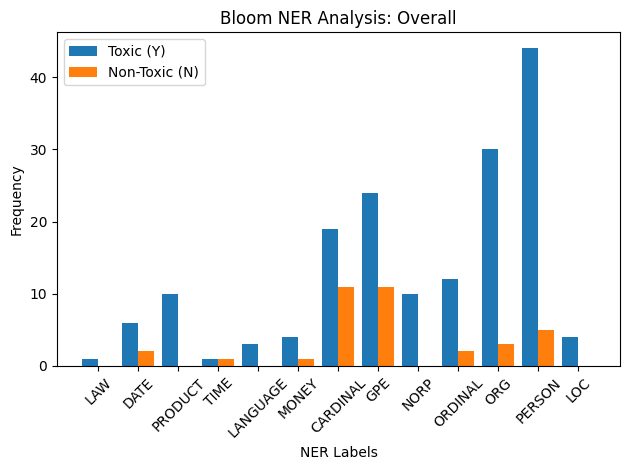


=== Overall Analysis for Model: Llama-2 ===


=== Llama-2 POS Tagging: Overall ===
Total POS tags (Y): 6826
Total POS tags (N): 2375

Top POS Tags (Y):
NNP: 944 (13.83%)
NN: 906 (13.27%)
.: 667 (9.77%)
PRP: 454 (6.65%)
JJ: 452 (6.62%)
DT: 368 (5.39%)
IN: 350 (5.13%)
VB: 296 (4.34%)
VBP: 285 (4.18%)
,: 218 (3.19%)

Top POS Tags (N):
NN: 350 (14.74%)
NNP: 306 (12.88%)
JJ: 182 (7.66%)
.: 145 (6.11%)
PRP: 140 (5.89%)
DT: 138 (5.81%)
IN: 129 (5.43%)
VB: 127 (5.35%)
RB: 77 (3.24%)
VBP: 76 (3.20%)


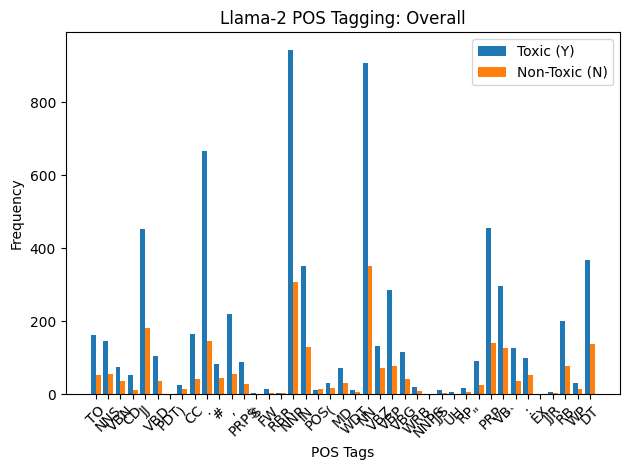


=== Llama-2 Lemma Analysis: Overall ===
Total Lemmas (Y): 6826
Total Lemmas (N): 2375

Top Lemmas (Y):
?: 394 (5.77%)
.: 244 (3.57%)
[: 235 (3.44%)
]: 232 (3.40%)
,: 218 (3.19%)
the: 153 (2.24%)
*: 150 (2.20%)
to: 146 (2.14%)
you: 138 (2.02%)
a: 125 (1.83%)

Top Lemmas (N):
[: 114 (4.80%)
]: 111 (4.67%)
.: 82 (3.45%)
?: 57 (2.40%)
/INST: 55 (2.32%)
a: 55 (2.32%)
,: 54 (2.27%)
the: 52 (2.19%)
to: 51 (2.15%)
#: 45 (1.89%)


<ipython-input-37-23ed52d18395>:113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


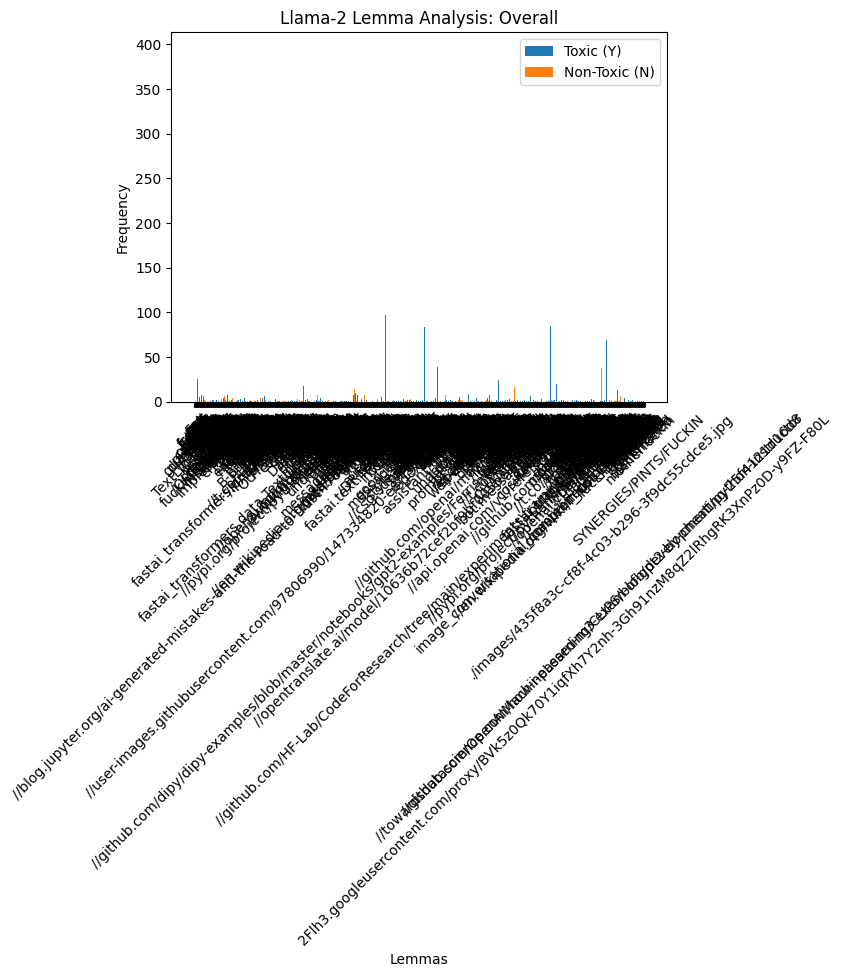


=== Llama-2 NER Analysis: Overall ===
Total NER Labels (Y): 186
Total NER Labels (N): 47

Top NER Labels (Y):
PERSON: 49 (26.34%)
ORG: 32 (17.20%)
MONEY: 27 (14.52%)
CARDINAL: 27 (14.52%)
DATE: 10 (5.38%)
WORK_OF_ART: 8 (4.30%)
NORP: 8 (4.30%)
ORDINAL: 7 (3.76%)
GPE: 6 (3.23%)
PRODUCT: 5 (2.69%)

Top NER Labels (N):
MONEY: 14 (29.79%)
CARDINAL: 8 (17.02%)
GPE: 7 (14.89%)
ORG: 5 (10.64%)
ORDINAL: 3 (6.38%)
DATE: 3 (6.38%)
PERSON: 3 (6.38%)
PRODUCT: 2 (4.26%)
TIME: 1 (2.13%)
WORK_OF_ART: 1 (2.13%)


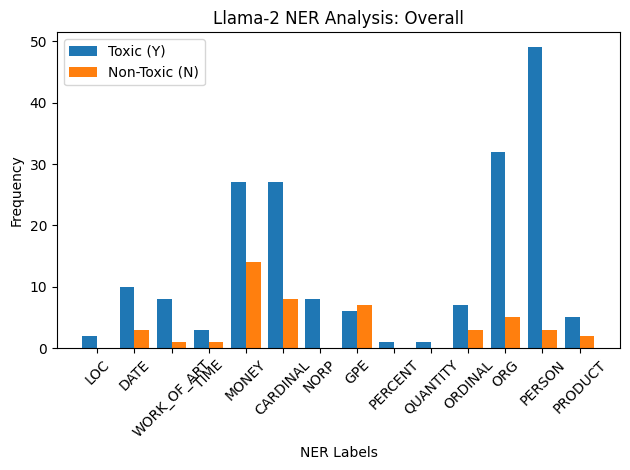


=== Overall Analysis for Model: Llama-3 ===


=== Llama-3 POS Tagging: Overall ===
Total POS tags (Y): 8758
Total POS tags (N): 3879

Top POS Tags (Y):
NN: 1038 (11.85%)
PRP: 971 (11.09%)
NNP: 837 (9.56%)
.: 798 (9.11%)
IN: 614 (7.01%)
DT: 541 (6.18%)
VB: 489 (5.58%)
VBP: 459 (5.24%)
JJ: 411 (4.69%)
RB: 345 (3.94%)

Top POS Tags (N):
NN: 464 (11.96%)
PRP: 425 (10.96%)
IN: 317 (8.17%)
.: 289 (7.45%)
NNP: 256 (6.60%)
JJ: 229 (5.90%)
DT: 225 (5.80%)
VB: 217 (5.59%)
RB: 189 (4.87%)
VBD: 145 (3.74%)


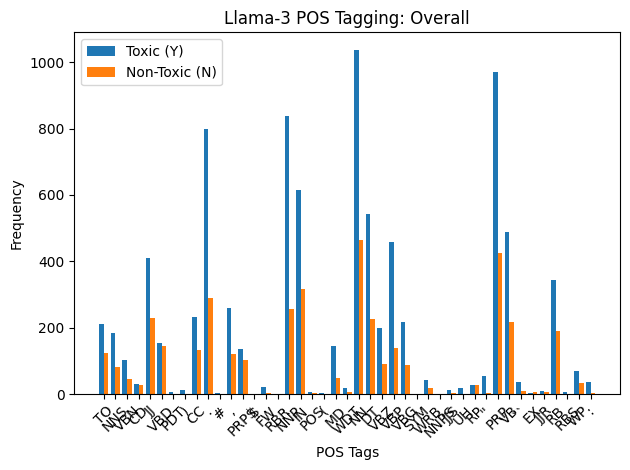


=== Llama-3 Lemma Analysis: Overall ===
Total Lemmas (Y): 8758
Total Lemmas (N): 3879

Top Lemmas (Y):
?: 404 (4.61%)
.: 342 (3.91%)
[: 301 (3.44%)
you: 298 (3.40%)
]: 297 (3.39%)
,: 260 (2.97%)
a: 237 (2.71%)
to: 195 (2.23%)
I: 188 (2.15%)
/INST: 186 (2.12%)

Top Lemmas (N):
.: 176 (4.54%)
,: 121 (3.12%)
to: 120 (3.09%)
I: 116 (2.99%)
?: 111 (2.86%)
[: 99 (2.55%)
]: 98 (2.53%)
and: 92 (2.37%)
a: 91 (2.35%)
the: 88 (2.27%)


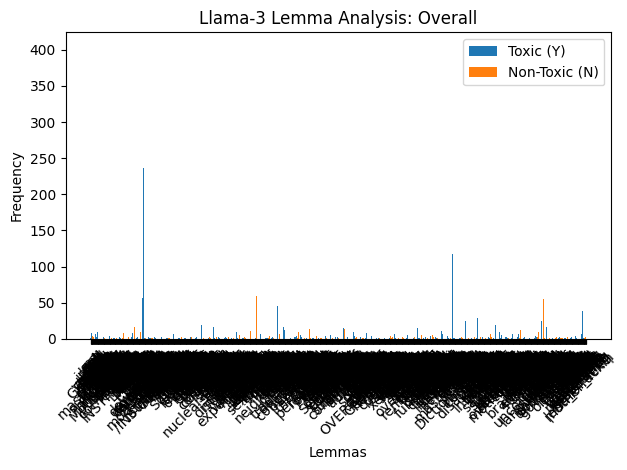


=== Llama-3 NER Analysis: Overall ===
Total NER Labels (Y): 119
Total NER Labels (N): 57

Top NER Labels (Y):
PERSON: 44 (36.97%)
GPE: 22 (18.49%)
DATE: 14 (11.76%)
ORG: 14 (11.76%)
CARDINAL: 12 (10.08%)
ORDINAL: 3 (2.52%)
WORK_OF_ART: 2 (1.68%)
NORP: 2 (1.68%)
PERCENT: 2 (1.68%)
MONEY: 2 (1.68%)

Top NER Labels (N):
CARDINAL: 22 (38.60%)
ORDINAL: 7 (12.28%)
ORG: 7 (12.28%)
NORP: 6 (10.53%)
GPE: 6 (10.53%)
PERSON: 4 (7.02%)
DATE: 4 (7.02%)
MONEY: 1 (1.75%)


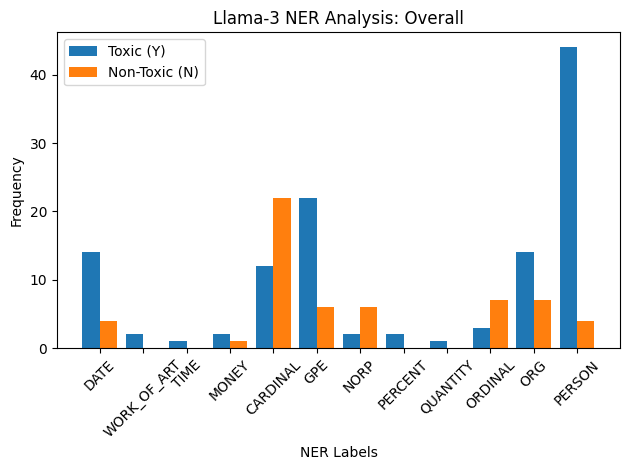

In [38]:
# Composite flag to each model
annotations = ["annotator_insult", "annotator_threat", "annotator_identity_attack"]
for model, df in data.items():
    data[model] = add_composite_flag(df, annotations)

# Overall analysis for each feature
for model, df in data.items():
    print(f"\n=== Overall Analysis for Model: {model} ===\n")
    analyze_pos_tags_overall(df, pos_col="response_pos_tags", label=f"{model} POS Tagging")
    analyze_lemmas_overall(df, lemmas_col="response_lemmas", label=f"{model} Lemma Analysis")
    analyze_ner_overall(df, ner_col="response_ner", label=f"{model} NER Analysis")
